# Evaluation Process

### In this document, we will discuss the use of the model that has just been built and interpret the results for the business.

In [1]:
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [2]:
df = pd.read_csv('../Data/data_ready.csv')
df.drop(df.columns[0], axis = 1, inplace = True)
df.head(4)

,cons_12m,cons_gas_12m,cons_last_month,forecast_base_bill_ele,forecast_cons,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,...,date_renewal_2015.0,has_gas_f,has_gas_t,origin_up_Miss,origin_up_ewxe,origin_up_kamk,origin_up_ldks,origin_up_lxid,origin_up_usap,price_date_2015.0
0,4.310267,0.0,4.001128,335.807483,206.800605,3.179547,2.932604,0.0,62.642961,0.095919,...,1,1,0,0,0,0,1,0,0,1
1,4.310267,0.0,4.001128,335.807483,206.800605,3.179547,2.932604,0.0,62.642961,0.095919,...,1,1,0,0,0,0,1,0,0,1
2,4.310267,0.0,4.001128,335.807483,206.800605,3.179547,2.932604,0.0,62.642961,0.095919,...,1,1,0,0,0,0,1,0,0,1
3,4.310267,0.0,4.001128,335.807483,206.800605,3.179547,2.932604,0.0,62.642961,0.095919,...,1,1,0,0,0,0,1,0,0,1


In [3]:
# Load Model

filename = './random_forest_classifier.joblib.pkl'
model_ = joblib.load(filename)

In [4]:
df['predictions'] = model_.predict(df.drop('churn', axis = 1))
df['predictions_prob'] = model_.predict_proba(df.drop(['churn', 'predictions'], axis = 1))[:, 1]

In [5]:
predictions = df[['churn', 'predictions', 'predictions_prob']]

## Final Data Showcase

In [6]:
df = pd.read_csv('../Data/cleaned_data.csv')
df.drop(df.columns[0], axis = 1, inplace = True)

In [7]:
df = df.join(predictions.drop('churn', axis = 1))
df.to_csv('../Data/final_data.csv')

#### This is the final data that will be used for the evaluation process. It include the original information before feature engineering and predictions results from the Random Forest Model

# Evaluation on Discount Policy

We will now evaluate whether giving a certain amount of discount will increase the company's profability. 

There are several assumption needed for this analysis that will be mentioned to prevent bias judgement.

1. Since we already have a predictions probability on whether a certain customer will churn or not, we will choose a cutoff point to handle customer with predictions probability to churn bigger than our cutoff to receive discount policy.

2. After the customer was given the discount, we'll assume that certain customer won't churn, which is sometimes not the case.

3. To get the revenue received by the company, we calculate the energy consumption with the price added with the meter rent. The calculation will be using the forecasted value for 12 months. (Note: Since we don't know when will the customer churn during the year, we will use the average revenues lost based on the period of time between 1 January 2016 and the start of March 2016, with 100% lost revenue if customer churned from January and 83.9% lost if the customer churned at the end of February, #guided by the BCG Inside Sherpa Report)

The data used for the final analysis is the final showcase data.

In [8]:
df = pd.read_csv('../Data/final_data.csv')
df.drop(df.columns[0], axis = 1, inplace = True)

### 1. Produce Baseline Revenue for Further Benchmarking Process

#### To calculate revenue, we need the forecasted consumption for 12 months times the price for the first period added with the forecasted meter rent for 12 months. This will be the baseline revenues for PowerCo if there are no customer that ended up churning during the time period.

In [9]:
df['baseline_revenue'] = df['forecast_cons_12m'] * df['forecast_price_energy_p1'] + df['forecast_meter_rent_12m']

print('The baseline revenues before accounting' \
      + ' for people churning is ${:.2f} millions'.format(df['baseline_revenue'].sum() / 10**6))

The baseline revenues before accounting for people churning is $71.69 millions


### 2. Calculate Baseline Revenue After churn

#### Since people that churned meant that the revenue from that specific customer will be lost, We should calculate the estimate revenues that PowerCo got after accounting for people churning.

In [10]:
df['baseline_revenue_after_churn'] = df['baseline_revenue'] * (1 - 0.919 * df['churn'])

In [11]:
print('The baseline revenues after accounting' \
      + ' for people churning is ${:.2f} millions'.format(df['baseline_revenue_after_churn'].sum() / 10**6))

The baseline revenues after accounting for people churning is $64.85 millions


### 3. Calculate the difference for the revenue after the discount has been given

#### First, create another data that gathers information about  revenue generated from the customer, we can use the baseline revenue after churning for this part.

#### Given a prediction probabilites higher than a cutoff point, PowerCo will give a discount policy reducing the revenues that is generated from that specific customer, but preventing them from churning. Then we can calculate the total revenues and compare it to the revenue if discount policy isn't given.

In [12]:
def diff_revenue(data = df, cutoff = 0.6, disc = 0.25):
    
    df['disc_rev'] = df['baseline_revenue_after_churn']
    
    # locate user with churn probabilities higher than cutoff.
    df.loc[df['predictions_prob'] >= cutoff, 'disc_rev'] = df['baseline_revenue'] * (1- disc)
    
    # Return the difference before and after discount is imposed
    return df['disc_rev'].sum() - df['baseline_revenue_after_churn'].sum()

print('Difference between revenues before and after giving discount to consumer' \
      + ' is ${:.2f} millions'.format(diff_revenue()/10**6))

Difference between revenues before and after giving discount to consumer is $4.94 millions


### Since cutoff can affect this analysis, we can plot a graph that showed the relationship between revenue differences and cutoff points.

In [13]:
revenue_gain = pd.DataFrame([diff_revenue(df, cutoff = x) for x in np.arange(0, 1, 0.01)], 
                            index = np.arange(0, 1, 0.01), columns = ['Revenue Gain']) / 10**6
revenue_gain['Different Compared to Previous Cutoff'] = 0
for index in range(1, len(revenue_gain)):
    rev_normalized = revenue_gain['Revenue Gain'] + np.min(revenue_gain['Revenue Gain'])
    increase = 100*((revenue_gain.iloc[index, 0] - revenue_gain.iloc[index-1, 0])/revenue_gain.iloc[index, 0]) 
    revenue_gain.iloc[index, 1] = increase

The best cutoff point with the highest reward is 0.25


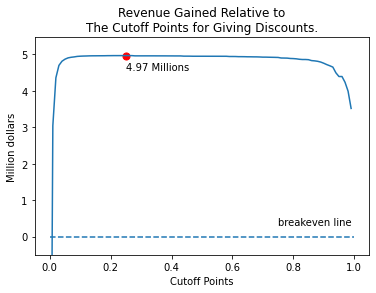

In [14]:
def plot_rev_increase(revenue_gain):
    sns.lineplot(x = revenue_gain.index, y = revenue_gain['Revenue Gain'])
    plt.scatter(revenue_gain['Revenue Gain'].idxmax(), np.max(revenue_gain['Revenue Gain']), s= 50, color = 'red')
    plt.ylim(-.5, np.max(revenue_gain['Revenue Gain']) + 0.5)
    plt.ylabel('Million dollars')
    plt.xlabel('Cutoff Points')
    plt.hlines(0, 0, 1, linestyles = 'dashed')

    plt.annotate(text = '{:.2f} Millions'.format(np.max(revenue_gain['Revenue Gain'])), 
                 xy = (revenue_gain['Revenue Gain'].idxmax(), 
                 np.max(revenue_gain['Revenue Gain']) - 0.4))

    plt.annotate(text = 'breakeven line',xy = (0.75, 0.3))

    plt.title('Revenue Gained Relative to\nThe Cutoff Points for Giving Discounts.');

    print('The best cutoff point with the highest reward is {}'.format(revenue_gain['Revenue Gain'].idxmax()))
plot_rev_increase(revenue_gain)

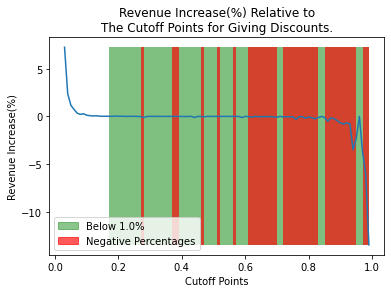

In [15]:
def cutoff_revenue_delta_plot(revenue_gain, thres):
    sns.lineplot(x = revenue_gain.index, y = revenue_gain['Different Compared to Previous Cutoff'], )
    
    
    indx = np.array(revenue_gain[revenue_gain['Different Compared to Previous Cutoff'] <= thres].index)
    minid = np.min(indx[1:])
    maxid = np.max(indx)
   
    
    plt.fill_between(x = revenue_gain.index, y1= np.min(revenue_gain.iloc[:, 1]), y2 = np.max(revenue_gain.iloc[:, 1]),  
                    where = (revenue_gain.index >= minid) & (revenue_gain.index <= maxid),
                    facecolor='green', alpha=0.5)
    
    plt.fill_between(x = revenue_gain.index, y1= np.min(revenue_gain.iloc[:, 1]), y2 = np.max(revenue_gain.iloc[:, 1]),  
                    where = revenue_gain['Different Compared to Previous Cutoff'] < 0,
                    facecolor='red', alpha=0.65)

    plt.title('Revenue Increase(%) Relative to\nThe Cutoff Points for Giving Discounts.')
    plt.xlabel('Cutoff Points')
    
    plt.ylabel('Revenue Increase(%)')
    
    
    legend_elements = [Patch(facecolor='green', edgecolor='green', alpha = 0.45,
                             label='Below {}%'.format(thres*100)),
                       Patch(facecolor='red', edgecolor='r', alpha = 0.65,
                             label='Negative Percentages')]
    
    plt.legend(handles=legend_elements, loc='lower left')
    plt.show()
    
cutoff_revenue_delta_plot(revenue_gain.iloc[3:, :], 0.01)

### As we can see from both graph presented,  selecting cutoff can affect the total amount of revenues increase that we get from this model, We will choosef 0.32 as the cutoff as it gave the most profitable result from the other cutoff points.

#### Note that this prediction is a very optimistic estimate. The deployment on real world case can yield various results.

# Conclusion

## Based on the analysis that we did, we can conclude that imposing discount for customer that have the probability to churn higher than 0.32 can increase our total revenues by an estimate of 4.97 Million Dollars.

### 